In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
color = sns.color_palette()

In [2]:
train = pd.read_csv('/Users/arijitchandra/Downloads/AV_research_category/train.csv')
test = pd.read_csv('/Users/arijitchandra/Downloads/AV_research_category/test.csv')
sub = pd.read_csv('/Users/arijitchandra/Downloads/AV_research_category/sample_sub.csv')

In [3]:
train.shape, test.shape, sub.shape

((20972, 9), (8989, 3), (8989, 7))

In [4]:
combined_df = train.append(test,ignore_index=True)

In [5]:
## Checking blank values in train dataset
train.isna().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [6]:
## Checking blank values in test dataset
test.isna().sum()

ID          0
TITLE       0
ABSTRACT    0
dtype: int64

In [7]:
df_label = pd.DataFrame(train.drop(['ID', 'TITLE','ABSTRACT'], axis=1))
counts = []
topics = list(df_label.columns.values)
for i in topics:
    counts.append((i, df_label[i].sum()))
df_stats = pd.DataFrame(counts, columns=['topics', 'counts'])
df_stats

,topics,counts
0,Computer Science,8594
1,Physics,6013
2,Mathematics,5618
3,Statistics,5206
4,Quantitative Biology,587
5,Quantitative Finance,249


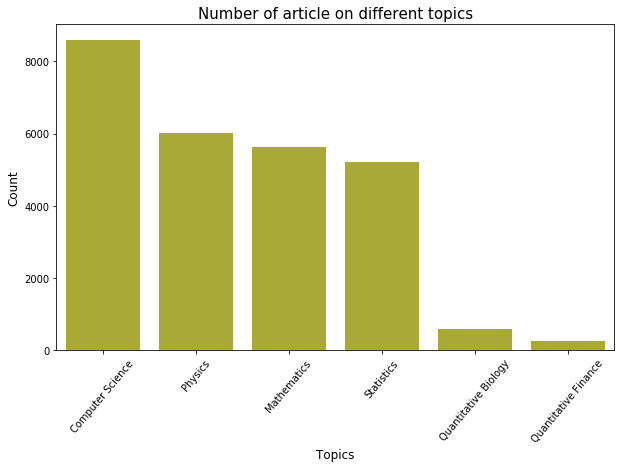

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(x="topics",y='counts',data=df_stats, color=color[8])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Topics',fontsize=12)
plt.xticks(rotation=50)
plt.title('Number of article on different topics', fontsize=15)
plt.show()

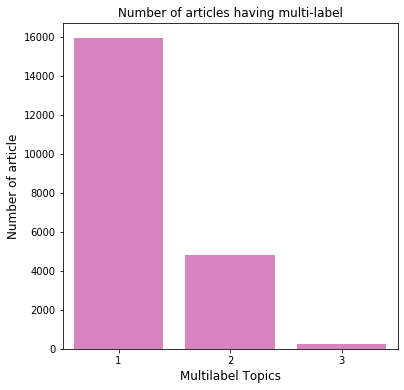

In [9]:
plt.figure(figsize=(6,6))
sns.barplot(x=df_label.sum(axis=1).value_counts().index, y=df_label.sum(axis=1).value_counts().values, color=color[6])
plt.ylabel('Number of article', fontsize=12)
plt.xlabel('Multilabel Topics',fontsize=12)
plt.title('Number of articles having multi-label', fontsize=12)
plt.show()

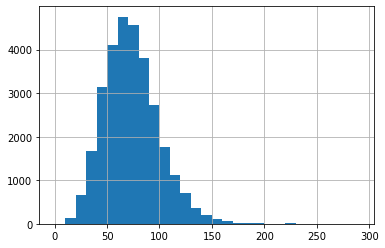

In [10]:
## Distribution of the number of characters in TITLE of article.

combined_df.TITLE.str.len().hist(bins = np.arange(0,300,10))

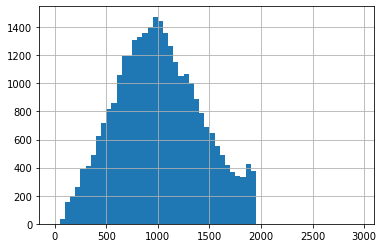

In [11]:
## Distribution of the number of characters in ABSTRACT of article.

combined_df.ABSTRACT.str.len().hist(bins = np.arange(0,3000,50))

In [12]:
def preprocess_text(sen):
    # Removing New line character
    sentence = re.sub(r'\n', ' ', sen)
    
    # Removing - and _ between words for combining
    sentence = re.sub(r'[-_]', '', sentence)
    
    # Remove punctuations and special character
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # remove backslash-apostrophe 
    sentence = re.sub("\'", "", sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z0-9]\s+", ' ', sentence)
    
    #sentence = re.sub(r"\s[0-9]+\s", '', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Converting to lower case
    sentence = sentence.lower()

    return sentence

In [13]:
preprocess_text(combined_df.ABSTRACT[5])

#combined_df.ABSTRACT[6]

' let omega subset mathbb n be bounded domain satisfying haymantype asymmetry condition and let be an arbitrary bounded domain referred to as obstacle we are interested in the behaviour of the first dirichlet eigenvalue lambda omega setminus d first we prove an upper bound on lambda omega setminus d in terms of the distance of the set d to the set of maximum points of the first dirichlet ground state phi lambda of omega in short direct corollary is that if begin equation mu omega max lambda omega setminus d end equation is large enough in terms of lambda omega then all maximizer sets d of mu omega are close to each maximum point of phi lambda second we discuss the distribution of phi lambda omega and the possibility to inscribe wavelength balls at given point in omega finally we specify our observations to convex obstacles and show that if mu omega is sufficiently large with respect to lambda omega then all maximizers d of mu omega contain all maximum points of phi lambda omega '

In [14]:
combined_df['clean_ABSTRACT'] = combined_df.ABSTRACT.apply(preprocess_text)
#train['clean_ABSTRACT'] = train.ABSTRACT.apply(preprocess_text)
#test['clean_ABSTRACT'] = test.ABSTRACT.apply(preprocess_text)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [16]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

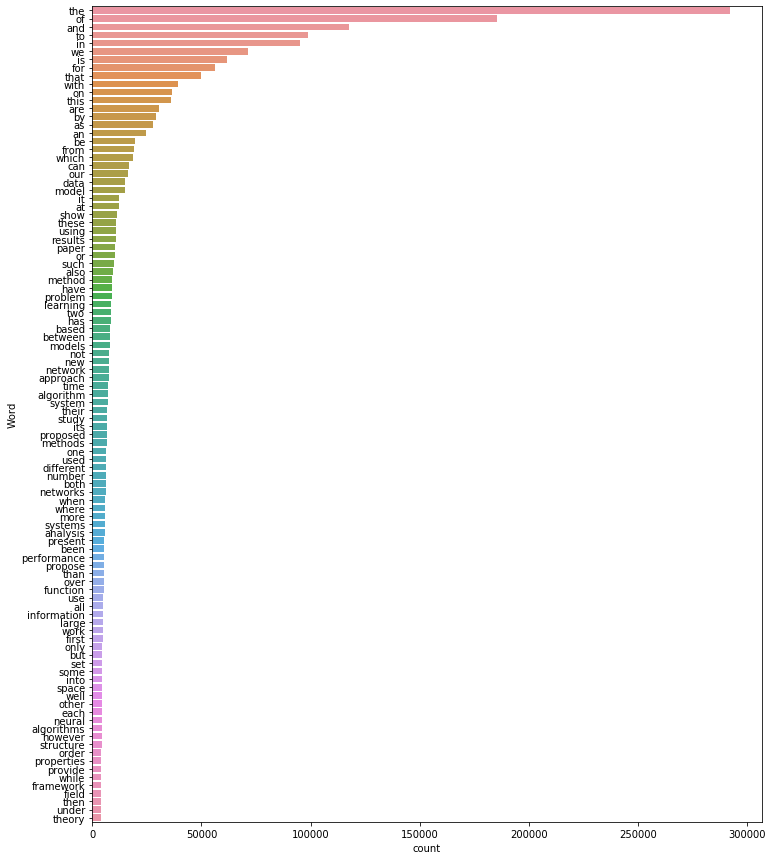

In [17]:
# print 100 most frequent words 
freq_words(combined_df['clean_ABSTRACT'], 100)

In [18]:
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

In [19]:
combined_df['clean_ABSTRACT'] = combined_df['clean_ABSTRACT'].apply(remove_stopwords)
#train['clean_ABSTRACT'] = train['clean_ABSTRACT'].apply(remove_stopwords)
#test['clean_ABSTRACT'] = test['clean_ABSTRACT'].apply(remove_stopwords)

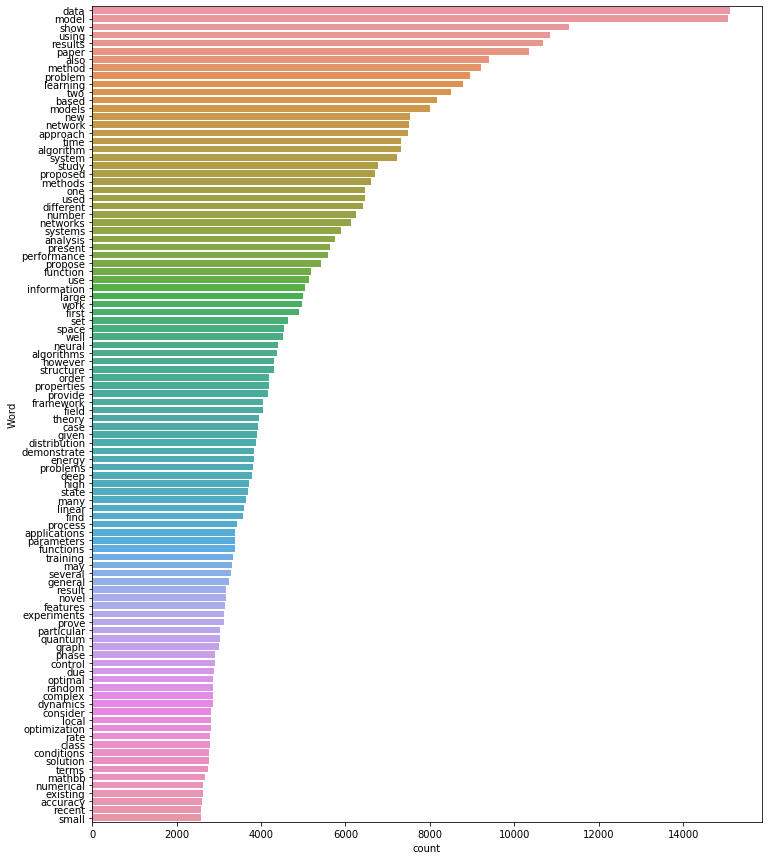

In [20]:
# print 100 most frequent words after removing stopwords
freq_words(combined_df['clean_ABSTRACT'], 100)

In [21]:
combined_df['clean_ABSTRACT'] = combined_df.TITLE +' '+ combined_df.clean_ABSTRACT

In [22]:
tokenized_abstract = combined_df.clean_ABSTRACT.apply(lambda x: x.split())
tokenized_abstract.head()

0    [Reconstructing, Subject-Specific, Effect, Map...
1    [Rotation, Invariance, Neural, Network, rotati...
2    [Spherical, polyharmonics, and, Poisson, kerne...
3    [A, finite, element, approximation, for, the, ...
4    [Comparative, study, of, Discrete, Wavelet, Tr...
Name: clean_ABSTRACT, dtype: object

In [23]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_abstract_stem = tokenized_abstract.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_abstract_stem.head()

0    [reconstruct, subject-specif, effect, map, pre...
1    [rotat, invari, neural, network, rotat, invari...
2    [spheric, polyharmon, and, poisson, kernel, fo...
3    [A, finit, element, approxim, for, the, stocha...
4    [compar, studi, of, discret, wavelet, transfor...
Name: clean_ABSTRACT, dtype: object

In [24]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

tokenized_abstract_lemm = \
tokenized_abstract.apply(lambda x: [wordnet_lemmatizer.lemmatize(i,pos='v') for i in x]) # Lemmatization
tokenized_abstract_lemm.head()

0    [Reconstructing, Subject-Specific, Effect, Map...
1    [Rotation, Invariance, Neural, Network, rotati...
2    [Spherical, polyharmonics, and, Poisson, kerne...
3    [A, finite, element, approximation, for, the, ...
4    [Comparative, study, of, Discrete, Wavelet, Tr...
Name: clean_ABSTRACT, dtype: object

In [25]:
for i in range(len(tokenized_abstract_stem)):
    tokenized_abstract_stem[i] = ' '.join(tokenized_abstract_stem[i])

combined_df['clean_ABSTRACT'] = tokenized_abstract_stem

In [ ]:
#from nltk.corpus import stopwords 
#stopset = set(stopwords.words('english')) 
#filter_stops = lambda w: len(w) < 3 or w in stopset

In [ ]:
#key =[]
#for i in combined_df['clean_ABSTRACT']:
#    j = i.split()
#    for p in j:
#        p = p.lstrip(' ')
#        p = p.rstrip(' ')
#        flag = 1
#        if(len(p)<2):
#            flag = 0
#        if(flag):
#            key.append(p)

In [ ]:
#from nltk.collocations import BigramCollocationFinder
#from nltk.metrics import BigramAssocMeasures
#
#biagram_collocation = BigramCollocationFinder.from_words(key)
# 
#biagram_collocation.apply_word_filter(filter_stops)
#biagram_collocation.apply_freq_filter(2)
#list1 = biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5000)
##biagram_collocation.nbest(BigramAssocMeasures.chi_sq, 5)

In [ ]:
#from nltk.collocations import TrigramCollocationFinder 
#from nltk.metrics import TrigramAssocMeasures 
#
#trigram_collocation = TrigramCollocationFinder.from_words(key) 
#trigram_collocation.apply_word_filter(filter_stops) 
#trigram_collocation.apply_freq_filter(2) 
#  
#list2 = trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 3000) 

In [ ]:
#text = combined_df.clean_ABSTRACT[0]
#biagram_measure = BigramAssocMeasures()
#biagram_collocation.score_ngrams(biagram_measure.pmi)

#listtocheck =[]
#listtowork = list1 + list2
#for i in listtowork:
#    sent =[]
#    for j in i:
#        sent.append(j)
#        stri = ' '.join(sent)
#        listtocheck.append(stri)
#print(len(listtocheck))

In [ ]:

#from nltk.collocations import BigramCollocationFinder
#from nltk.metrics import BigramAssocMeasures
#from nltk.collocations import TrigramCollocationFinder 
#from nltk.metrics import TrigramAssocMeasures
#
#from nltk.corpus import stopwords 
#stopset = set(stopwords.words('english')) 
#filter_stops = lambda w: len(w) < 3 or w in stopset
#
#def collocated_data(data):
#    key =[]
#    key = data.split()
#    #j = data.split()
#    #for p in j:
#    #    p = p.lstrip(' ')
#    #    p = p.rstrip(' ')
#    #    flag = 1
#    #    if(len(p)<2):
#    #        flag = 0
#    #    if(flag):
#    #        key.append(p)
#            
#    biagram_collocation = BigramCollocationFinder.from_words(key)
#    biagram_collocation.apply_word_filter(filter_stops)
#    biagram_collocation.apply_freq_filter(2)
#    list1 = biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 5000)
#    
#    trigram_collocation = TrigramCollocationFinder.from_words(key) 
#    trigram_collocation.apply_word_filter(filter_stops) 
#    trigram_collocation.apply_freq_filter(2) 
#    list2 = trigram_collocation.nbest(TrigramAssocMeasures.likelihood_ratio, 3000)
#    
#    listtocheck =[]
#    listtowork = list1 + list2
#    for i in listtowork:
#        sent =[]
#        for j in i:
#            sent.append(j)
#            
#            stri = ' '.join(sent)
#            stri = re.sub('\n',' ',stri)
#            listtocheck.append(stri)
#    return listtocheck

In [ ]:
#combined_df['collocated_data'] = combined_df.clean_ABSTRACT.apply(collocated_data)

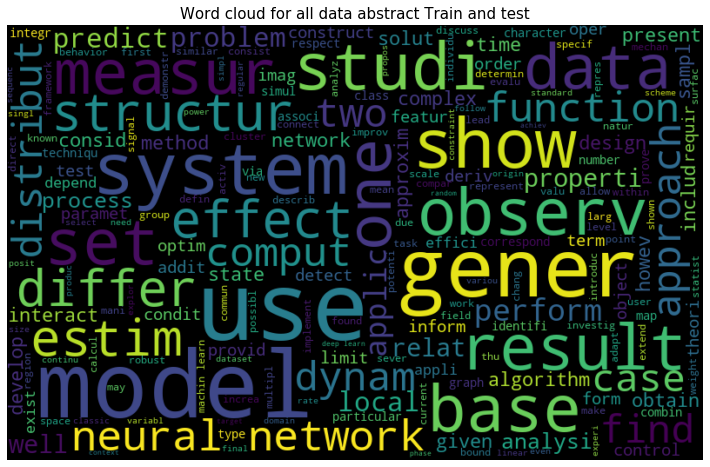

In [26]:
## Word cloud for entire train dataset
all_words = ' '.join([text for text in combined_df['clean_ABSTRACT']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for all data abstract Train and test', fontsize=15)
plt.axis('off')
plt.show()

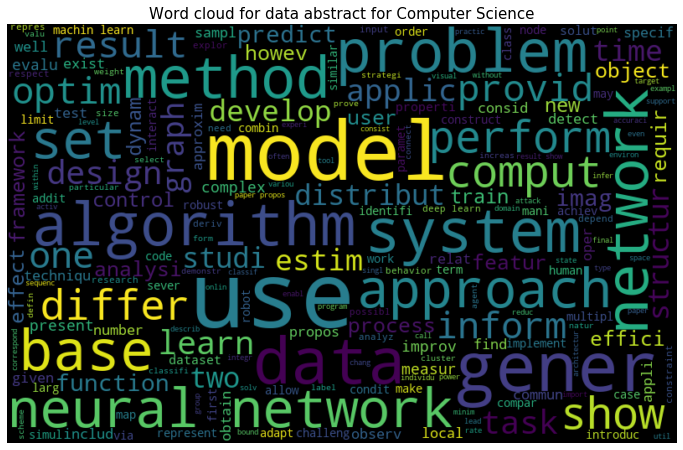

In [27]:
## Word cloud for train dataset for Computer Science
all_words = ' '.join([text for text in combined_df['clean_ABSTRACT'][combined_df['Computer Science']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for data abstract for Computer Science', fontsize=15)
plt.axis('off')
plt.show()

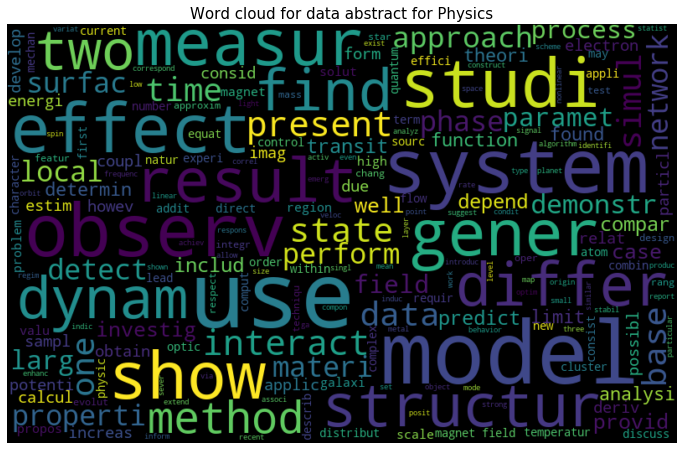

In [28]:
## Word cloud for train dataset for Physics
all_words = ' '.join([text for text in combined_df['clean_ABSTRACT'][combined_df['Physics']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for data abstract for Physics', fontsize=15)
plt.axis('off')
plt.show()

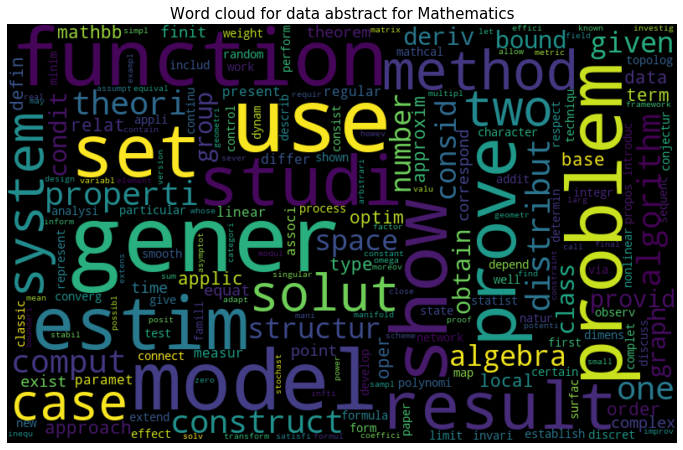

In [29]:
## Word cloud for train dataset for Mathematics
all_words = ' '.join([text for text in combined_df['clean_ABSTRACT'][combined_df['Mathematics']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for data abstract for Mathematics', fontsize=15)
plt.axis('off')
plt.show()

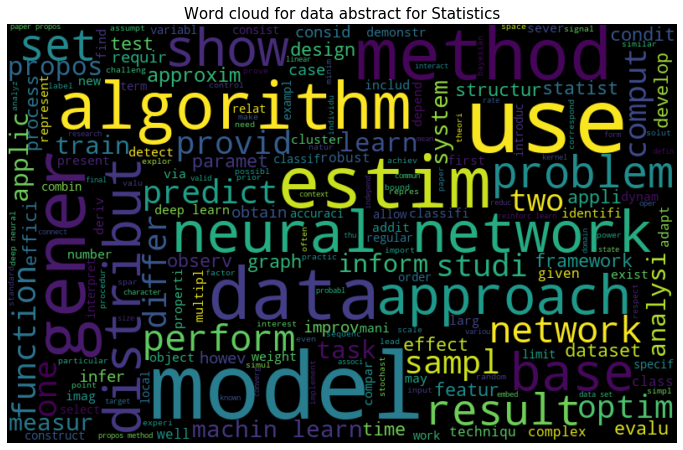

In [30]:
## Word cloud for train dataset for Statistics
all_words = ' '.join([text for text in combined_df['clean_ABSTRACT'][combined_df['Statistics']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for data abstract for Statistics', fontsize=15)
plt.axis('off')
plt.show()

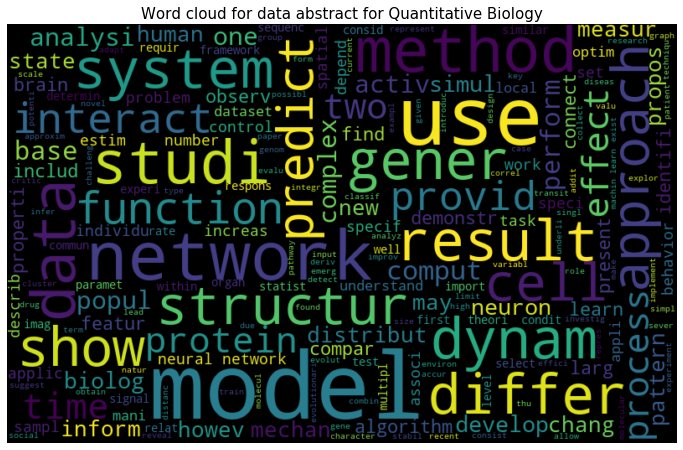

In [31]:
## Word cloud for train dataset for Quantitative Biology
all_words = ' '.join([text for text in combined_df['clean_ABSTRACT'][combined_df['Quantitative Biology']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for data abstract for Quantitative Biology', fontsize=15)
plt.axis('off')
plt.show()

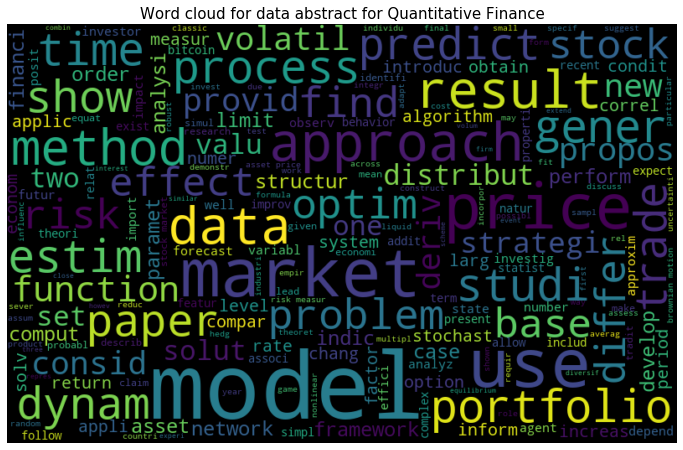

In [32]:
## Word cloud for train dataset for Quantitative Finance
all_words = ' '.join([text for text in combined_df['clean_ABSTRACT'][combined_df['Quantitative Finance']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word cloud for data abstract for Quantitative Finance', fontsize=15)
plt.axis('off')
plt.show()

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
#bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words=stop_words)
## bag-of-words feature matrix
#bow = bow_vectorizer.fit_transform(combined_df.clean_ABSTRACT)

In [ ]:
#train_bow = bow[:20972]
#train_y = df_label.values
#test_bow = bow[20972:]
#train_bow.shape,train_y.shape,test_bow.shape

In [33]:
train = combined_df[:20972]
test = combined_df[20972:]
train.shape, test.shape, sub.shape

((20972, 10), (8989, 10), (8989, 7))

In [34]:
from sklearn.metrics import f1_score
def micro_F1_score(actual, pred):
    return f1_score(actual,pred, average='micro')

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0.0, 
                                   #max_features=25000,
                                   stop_words=stop_words,ngram_range=(1,2))
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combined_df.clean_ABSTRACT)

In [36]:
tfidf_vectorizer.vocabulary_
tfidf.shape

(29961, 1390965)

In [37]:
train_tfidf = tfidf[:20972]
train_y = df_label.values
test_tfidf = tfidf[20972:]
train_tfidf.shape,train_y.shape,test_tfidf.shape

((20972, 1390965), (20972, 6), (8989, 1390965))

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_tfidf, train_y, test_size=0.1, random_state=41)
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

((18874, 1390965), (18874, 6), (2098, 1390965), (2098, 6))

### Linear SVC

In [39]:
from sklearn.metrics import f1_score
from sklearn.multioutput import MultiOutputClassifier
svc = LinearSVC(class_weight='balanced',
                random_state=42,C=1)
clf = OneVsRestClassifier(svc)
# fit model on train data
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1, class_weight='balanced',
                                        random_state=42))

In [40]:
# evaluate performance
print('micro F1 score on train set : {:.3f}'.format(micro_F1_score(y_train,clf.predict(X_train))))
print('micro F1 score on validation set : {:.3f}'.format(micro_F1_score(y_valid,clf.predict(X_valid))))

micro F1 score on train set : 0.998
micro F1 score on validation set : 0.816


In [41]:
target_cols=['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']

In [42]:
pred = clf.predict(test_tfidf)
sub[target_cols] = pred
sub.to_csv('submission.csv', index=False)

In [43]:
## Naive Bayes
nbc = MultinomialNB(alpha=.1,fit_prior=True, class_prior=None)
clf = OneVsRestClassifier(nbc)
# fit model on train data
clf.fit(X_train, y_train)

# evaluate performance
print('micro F1 score on train set : {:.3f}'.format(micro_F1_score(y_train,clf.predict(X_train))))
print('micro F1 score on validation set : {:.3f}'.format(micro_F1_score(y_valid,clf.predict(X_valid))))

micro F1 score on train set : 0.967
micro F1 score on validation set : 0.793


In [44]:
X = train.clean_ABSTRACT
X.values
y = df_label.values
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0]])

In [45]:
X_tst = test.clean_ABSTRACT.values

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_valid, y_train, y_valid = train_test_split(X.values, y, test_size=0.10, random_state=8)
#X_train.shape,y_train.shape,X_valid.shape,y_valid.shape

In [46]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Conv1D, MaxPooling1D, GlobalMaxPool1D
from keras.layers import GlobalMaxPooling1D, Bidirectional
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.utils import to_categorical

In [47]:
tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(X.values)

X_train = tokenizer.texts_to_sequences(X.values)
#X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_tst)

vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % vocab_size)
maxlen = 500

X_train = pad_sequences(X_train, padding='post')
#X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=X_train.shape[1])

Found 58101 unique tokens.


In [ ]:
#X_test = pad_sequences(X_test, padding='post', maxlen = 260)
#X_test.shape

In [48]:
X_train.shape, X_test.shape

((20972, 263), (8989, 263))

In [49]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/Users/arijitchandra/Downloads/glove/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()



In [50]:
#tokenizer.word_index.items()
#embeddings_dictionary.get('study')
all_embs = np.stack(embeddings_dictionary.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(-0.0039050116, 0.38177028)

In [51]:
embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, 300))
#embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

(58101, 300)


Text(0.5, 1.0, 'example vectors')

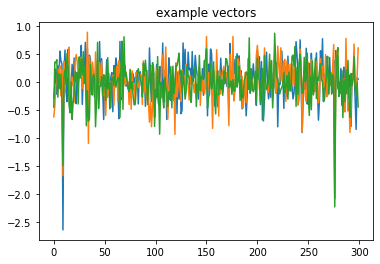

In [52]:
## Peeking at the embedding matrix values
print(embedding_matrix.shape)
plt.plot(embedding_matrix[8])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[40])
plt.title('example vectors')

In [ ]:
## prepare embedding matrix 
#from keras.layers import Embedding
#from keras.initializers import Constant
#
### EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
#EMBEDDING_DIM = embeddings_dictionary.get('a').shape[0]
#
## load pre-trained word embeddings into an Embedding layer
## note that we set trainable = False so as to keep the embeddings fixed
#embedding_layer = Embedding(vocab_size,
#                            EMBEDDING_DIM,
#                            embeddings_initializer=Constant(embedding_matrix),
#                            input_length=maxlen,
#                            trainable=False)

In [ ]:
#import tensorflow as tf
#model1 = tf.keras.Sequential([Input(shape=(maxlen,)),
#                             Embedding(vocab_size, 300, weights=[embedding_matrix]),
#                             Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
#                             Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
#                             GlobalMaxPool1D(),
#                             Dense(50, activation="relu"),
#                             Dropout(0.2),
#                             Dense(6, activation="sigmoid")
#                            ])
##optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
#model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
import tensorflow as tf
model = Sequential()
model.add(Embedding(vocab_size, 300,  input_length=X_train.shape[1], weights= [embedding_matrix], trainable=False))

#model.add(Dropout(0.1))
model.add(Conv1D(128, 6, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
#model.add(Conv1D(64, 6, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(128,return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model.add(GlobalMaxPool1D())
model.add(Dense(6, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 263, 300)          17430300  
_________________________________________________________________
conv1d (Conv1D)              (None, 258, 128)          230528    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 256)           263168    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 1542      
Total params: 17,925,538
Trainable params: 495,238
Non-trainable params: 17,430,300
______________________________________

In [55]:
history = model.fit(X_train, df_label.values,
                    #class_weight='balanced',
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[])

Epoch 1/5
263/263 [==============================] - 140s 534ms/step - loss: 0.2745 - accuracy: 0.6912 - val_loss: 0.2257 - val_accuracy: 0.7185
Epoch 2/5
263/263 [==============================] - 139s 529ms/step - loss: 0.2024 - accuracy: 0.7520 - val_loss: 0.2185 - val_accuracy: 0.7743
Epoch 3/5
263/263 [==============================] - 141s 538ms/step - loss: 0.1729 - accuracy: 0.7761 - val_loss: 0.2009 - val_accuracy: 0.7533
Epoch 4/5
263/263 [==============================] - 141s 536ms/step - loss: 0.1442 - accuracy: 0.7969 - val_loss: 0.2205 - val_accuracy: 0.7545
Epoch 5/5
263/263 [==============================] - 154s 586ms/step - loss: 0.1163 - accuracy: 0.8164 - val_loss: 0.2166 - val_accuracy: 0.7397


In [ ]:
#import tensorflow as tf
#model = Sequential()
#model.add(Embedding(vocab_size, 300,  input_length=maxlen, weights= [embedding_matrix], trainable=False))
#model.add(Conv1D(128, 6, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
##model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
#model.add(GlobalMaxPool1D())
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(6, activation='sigmoid'))
#opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
#model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#print(model.summary())

In [ ]:
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=300, input_length=X_train.shape[1], weights= [embedding_matrix]))
model.add(LSTM(128, return_sequences=True))  
# Adding a dropout layer
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.1))
# Adding a dense output layer with sigmoid activation
model.add(Dense(6, activation='sigmoid'))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, df_label.values,
                    #class_weight='balanced',
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[])

In [56]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
predictions=model.predict(X_train)
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(df_label.values, pred, average='micro')
    recall = recall_score(df_label.values, pred, average='micro')
    f1 = f1_score(df_label.values, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.7338, Recall: 0.9740, F1-measure: 0.8370
Micro-average quality numbers
Precision: 0.8214, Recall: 0.9566, F1-measure: 0.8838
Micro-average quality numbers
Precision: 0.8664, Recall: 0.9390, F1-measure: 0.9012
Micro-average quality numbers
Precision: 0.8962, Recall: 0.9181, F1-measure: 0.9070
Micro-average quality numbers
Precision: 0.9175, Recall: 0.8921, F1-measure: 0.9046
Micro-average quality numbers
Precision: 0.9352, Recall: 0.8583, F1-measure: 0.8951
Micro-average quality numbers
Precision: 0.9516, Recall: 0.8109, F1-measure: 0.8757
Micro-average quality numbers
Precision: 0.9673, Recall: 0.7342, F1-measure: 0.8348
Micro-average quality numbers
Precision: 0.9826, Recall: 0.6071, F1-measure: 0.7505


In [ ]:
#from tensorflow.keras import backend
#backend.clear_session()
#history = model.fit(X_train, df_label.values,
#                    batch_size=32,
#                    epochs=5, 
#                    #verbose=10,
#                     validation_split=0.2) 

In [ ]:
#seed = 41
#np.random.seed(seed)
#deep_inputs = Input(shape=(maxlen,))
#embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(deep_inputs)
#LSTM_Layer_1 = LSTM(128)(embedding_layer)
#dense_layer_1 = Dense(6, activation='softmax')(LSTM_Layer_1)
#
#model = Model(inputs=deep_inputs, outputs=dense_layer_1)
#
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(X_train, df_label.values,
                    batch_size=32,
                    epochs=5)

In [57]:
val_loss, val_accuracy= model.evaluate(X_train, df_label.values, batch_size=32)
print(val_loss, val_accuracy)

656/656 [==============================] - 51s 77ms/step - loss: 0.1081 - accuracy: 0.8318
0.1081114336848259 0.8318234086036682


In [58]:
micro_F1_score(np.round(model.predict(X_train)),df_label.values)

0.904623105877811

In [59]:
pred = model.predict(X_test)

In [60]:
pred

array([[1.07336909e-01, 6.43068552e-03, 4.65983182e-01, 9.64004278e-01,
        2.28741765e-03, 3.25158238e-03],
       [9.16928053e-04, 9.99158204e-01, 1.38559937e-03, 1.36128068e-03,
        1.16199255e-03, 1.50948763e-04],
       [9.83555675e-01, 2.50306726e-03, 1.15103394e-01, 5.65444827e-02,
        5.48481941e-04, 4.09215689e-04],
       ...,
       [7.21193016e-01, 7.13194907e-02, 2.85884738e-03, 4.25579637e-01,
        2.97167361e-01, 9.45687294e-04],
       [6.47219896e-01, 3.08898091e-03, 1.29217237e-01, 8.42901587e-01,
        6.24537468e-03, 4.27514315e-04],
       [5.22743091e-02, 3.45739350e-03, 9.90681887e-01, 1.29225175e-03,
        2.44095936e-04, 3.41276173e-04]], dtype=float32)

In [61]:
np.round(pred)

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [62]:
#pred = np.round(pred+.2)
sub[target_cols] = np.round(pred+.1)
sub.to_csv('submission.csv', index=False)

In [63]:
from sklearn.model_selection import train_test_split
trn, val = train_test_split(train, random_state=42, test_size=0.1,
                            stratify=train[['Quantitative Biology','Quantitative Finance']],
                           shuffle = True)

trn.shape, val.shape

((18874, 10), (2098, 10))

In [64]:
X_train = trn.clean_ABSTRACT
X_valid = val.clean_ABSTRACT
X_test = test.clean_ABSTRACT
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(18874,)
(2098,)
(8989,)


## Naive Bayes

In [65]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=.2, min_df=0.0,stop_words=stop_words,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(MultinomialNB(alpha=.01,
                    fit_prior=True, class_prior=None))),
            ])

In [66]:
from sklearn.metrics import f1_score
for topic in df_label.columns:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, trn[topic])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_valid)
    print('Validation accuracy is {}'.format(f1_score(val[topic], prediction)))

... Processing Computer Science
Validation accuracy is 0.8502994011976047
... Processing Physics
Validation accuracy is 0.8934646374216653
... Processing Mathematics
Validation accuracy is 0.8291316526610644
... Processing Statistics
Validation accuracy is 0.7510548523206751
... Processing Quantitative Biology
Validation accuracy is 0.12698412698412698
... Processing Quantitative Finance
Validation accuracy is 0.21428571428571425


In [67]:
for topic in df_label.columns:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, trn[topic])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    sub[topic] = prediction
pred_nb = sub[df_label.columns]
sub.to_csv('submission.csv', index=False)

... Processing Computer Science
... Processing Physics
... Processing Mathematics
... Processing Statistics
... Processing Quantitative Biology
... Processing Quantitative Finance


## LinearSVC

In [68]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=.3, min_df=0.0,sublinear_tf= True,
                                          stop_words=stop_words,ngram_range=(1,2))),
                ('clf', LinearSVC(class_weight='balanced',random_state=42,C=1))
            ])

In [69]:
from sklearn.metrics import f1_score
for topic in df_label.columns:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, trn[topic])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_valid)
    print('Validation accuracy is {}'.format(f1_score(val[topic], prediction)))

... Processing Computer Science
Validation accuracy is 0.8554083885209713
... Processing Physics
Validation accuracy is 0.9030042918454935
... Processing Mathematics
Validation accuracy is 0.8254252461951657
... Processing Statistics
Validation accuracy is 0.7866894197952219
... Processing Quantitative Biology
Validation accuracy is 0.4166666666666667
... Processing Quantitative Finance
Validation accuracy is 0.6976744186046512


In [70]:
for topic in df_label.columns:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, trn[topic])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    sub[topic] = prediction

... Processing Computer Science
... Processing Physics
... Processing Mathematics
... Processing Statistics
... Processing Quantitative Biology
... Processing Quantitative Finance


In [71]:
pred_svc = sub[df_label.columns]
sub.to_csv('submission.csv', index=False)

## Logistic Regression

In [72]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=.2, min_df=0.0,stop_words=stop_words,ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag',
                                                              C=1,
                                                              class_weight='balanced',
                                                              random_state=42), n_jobs=-1)),
            ])

In [73]:
for topic in df_label.columns:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, trn[topic])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_valid)
    print('Validation accuracy is {}'.format(f1_score(val[topic], prediction)))

... Processing Computer Science
Validation accuracy is 0.8533772652388797
... Processing Physics
Validation accuracy is 0.8838383838383839
... Processing Mathematics
Validation accuracy is 0.8172043010752688
... Processing Statistics
Validation accuracy is 0.7619808306709265
... Processing Quantitative Biology
Validation accuracy is 0.5033112582781456
... Processing Quantitative Finance
Validation accuracy is 0.5714285714285714


In [74]:
for topic in df_label.columns:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, trn[topic])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    sub[topic] = prediction
pred_lr = sub[df_label.columns]
sub.to_csv('submission.csv', index=False)

... Processing Computer Science
... Processing Physics
... Processing Mathematics
... Processing Statistics
... Processing Quantitative Biology
... Processing Quantitative Finance


In [75]:
#voting_pred = np.round((pred_rf +pred_nb +2*pred_svc +pred_xgb + 1.5*pred_lr)/6.5).values
voting_pred = np.round((pred_lr + pred_svc)/2).values

In [76]:
sub[df_label.columns] = voting_pred
sub.to_csv('submission.csv', index=False)